In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from xgboost import XGBClassifier

from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer

import matplotlib.pyplot as plt

# pandas config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed = 2021

# IEEE fraud data

Download data with kaggle CLI if it is setup on your computer:

In [2]:
#!kaggle competitions download -c ieee-fraud-detection

Else you can download the data here: https://www.kaggle.com/c/ieee-fraud-detection/data, and you will have to accept the competition rules

In [3]:
df = pd.read_csv('data/train_transaction.csv')

In [4]:
print(df.shape)

(590540, 394)


# Preprocessing

In [5]:
# count missing values per column
missing_values = df.isnull().sum(axis=0)
missing_values

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [6]:
# keep only columns with less than 10000 values
selected_columns = [col for col in df.columns if missing_values[col] < 10000]

In [7]:
# in the resulting columns, drop rows with any missing value
df = df[selected_columns].dropna(axis=0, how='any')

In [8]:
# for the variable 'card6', keep only rows corresponding to 'debit' and 'credit'modalities
df = df.loc[df['card6'].isin(['debit', 'credit']), :].copy()
df['card6'] = (df['card6'] == 'credit') * 1

In [9]:
print(df.shape)
df.head()

(578048, 112)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sampling

We replicate a typical production situation where we would have:
- training data
- validation data
- test data
- production data

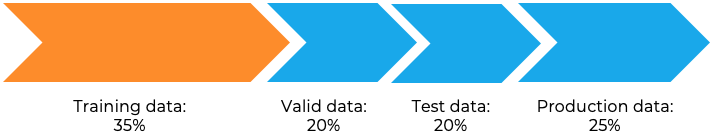

In [10]:
# select features by keeping only numerical features
features = [col for col in df.columns if col not in ['TransactionID', 'isFraud', 'TransactionDT',
                                                     'ProductCD', 'card4']]

In [11]:
# time split (shuffle=False) to seperate between df_temp (train + valid + test data) and df_prod (production data)
df_temp, df_prod = train_test_split(df, test_size=0.25, shuffle=False)

In [12]:
# time split (shuffle=False) to seperate between df_temp2 (train + valid data) and df_test (test data)
df_temp2, df_test = train_test_split(df_temp, test_size=0.25, shuffle=False)

In [13]:
# time split (shuffle=False) to seperate between train data and valid data
X_train, X_valid, y_train, y_valid = train_test_split(df_temp2[features], df_temp2['isFraud'].values,
                                                      test_size=1/3, shuffle=False)

In [14]:
# prod
X_prod, y_prod = df_prod[features], df_prod['isFraud'].values

In [15]:
# test
X_test, y_test = df_test[features], df_test['isFraud'].values

In [16]:
del df_temp

# Build model

In [17]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.2,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed,
                    early_stopping_rounds=20,
                    eval_metric=['auc', 'logloss'])

In [18]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], verbose=10)

[0]	validation_0-auc:0.78251	validation_0-logloss:0.53084
[10]	validation_0-auc:0.84549	validation_0-logloss:0.13390
[20]	validation_0-auc:0.87773	validation_0-logloss:0.10338
[30]	validation_0-auc:0.88472	validation_0-logloss:0.10100
[40]	validation_0-auc:0.88857	validation_0-logloss:0.10022
[50]	validation_0-auc:0.88950	validation_0-logloss:0.09990
[60]	validation_0-auc:0.89051	validation_0-logloss:0.09993
[70]	validation_0-auc:0.88957	validation_0-logloss:0.10016
[77]	validation_0-auc:0.88807	validation_0-logloss:0.10035


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=2021, reg_alpha=0, reg_lambda=1, ...)

In [34]:
#clf.save_model('xgb_demo_ieee2')

In [20]:
clf.load_model('xgb_demo_ieee2')

In [21]:
# setup cat features
cat_features = X_train.columns[X_train.apply(lambda x: len(x.value_counts()), axis=0) < 2000].to_list()
cat_feature_indices = [X_train.columns.to_list().index(feat) for feat in cat_features]

# Detection of data drift

We don not detect any data drift in the example below

In [22]:
# initialize and fit a model drift explainer on valid and test data
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_valid, X2=X_test, y1=y_valid, y2=y_test, cat_feature_indices=cat_feature_indices)

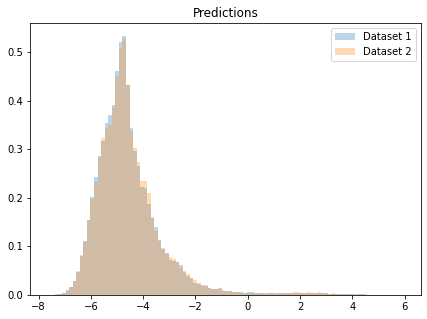

[DriftMetricsNum(mean_difference=0.020452334348579626, wasserstein=0.022159071787844292, ks_test=BaseStatisticalTestResult(statistic=0.011634558606436363, pvalue=8.431094096018793e-07))]

In [23]:
# no apparent drift in distribution of predictions
drift_explainer.plot_prediction_drift(bins=100)
drift_explainer.get_prediction_drift()

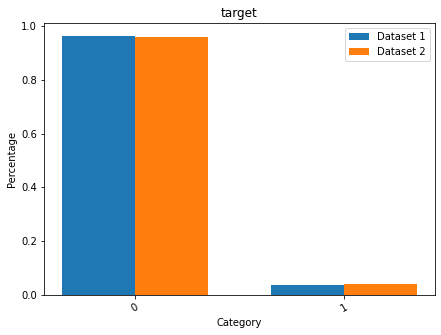

DriftMetricsCat(wasserstein=0.0018360643637437245, jensen_shannon=0.003376151123949227, chi2_test=Chi2TestResult(statistic=4.891628510259602, pvalue=0.026987218877238112, dof=1, contingency_table=           0       1
X1  104316.0  4068.0
X2  104117.0  4267.0))

In [24]:
# no apparent drift in distribution of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [25]:
# no apparent drift in performance metrics
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=0.9727081488042516, log_loss=0.09980704829516686), dataset2=ClassificationMetrics(accuracy=0.9708628579864187, log_loss=0.10793923691254616))

# Calibrate the monitoring on the test data

In [26]:
# compute the daily drift indicators on the test data, assuming there are "w" transations every day
# assume a situation with a delayed feedback so that it is not possible to rely on ground truth label to detect
# drift in production

def get_daily_indicators_df(X1, X2, y1, y2, w: int):
    daily_indicators = {}
    for i in range(len(X2) // w):
        drift_explainer = ModelDriftExplainer(clf)
        drift_explainer.fit(X1=X1, X2=X2.iloc[(i*w):(i+1)*w, :],
                            y1=y1, y2=y2[(i*w):(i+1)*w])
        prediction_drift = drift_explainer.get_prediction_drift()
        d = {}
        d['pred_mean_difference'] = prediction_drift[0].mean_difference
        d['pred_wasserstein'] = prediction_drift[0].wasserstein
        d['pred_ks_pvalue'] = prediction_drift[0].ks_test.pvalue
        daily_indicators[f'd{i}'] = d

    daily_indicators_df = pd.DataFrame.from_dict(daily_indicators, orient='index')
    return daily_indicators_df

In [27]:
daily_indicators_df = get_daily_indicators_df(X1=X_valid, X2=X_test, y1=y_valid, y2=y_test, w=1000)
daily_indicators_df

,pred_mean_difference,pred_wasserstein,pred_ks_pvalue
d0,-0.135532,0.136861,3.308983e-02
d1,-0.113213,0.135379,9.669951e-05
d2,0.021390,0.102525,1.149130e-02
d3,-0.104826,0.112374,2.531952e-01
d4,-0.115709,0.117648,1.577576e-02
d5,-0.186161,0.189804,3.318564e-06
d6,-0.113593,0.114152,2.509751e-01
d7,-0.018113,0.100822,1.247424e-01
d8,-0.121038,0.121404,1.000562e-01
d9,-0.017899,0.096349,2.056961e-01


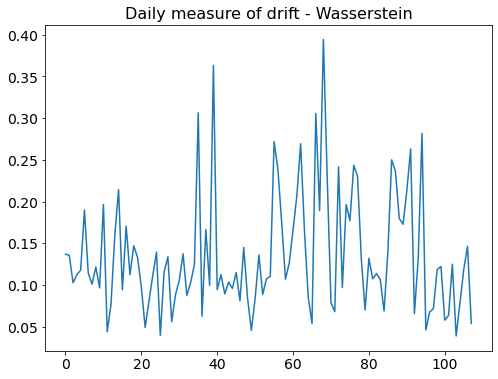

In [28]:
plt.subplots(figsize=(8, 6))
plt.plot(list(range(len(daily_indicators_df))), daily_indicators_df['pred_wasserstein'])
plt.title('Daily measure of drift - Wasserstein', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [30]:
i=68
w=1000
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_valid, X2=X_test.iloc[(i*w):(i+1)*w, :],
                    y1=y_valid, y2=y_test[(i*w):(i+1)*w], cat_feature_indices=cat_feature_indices)

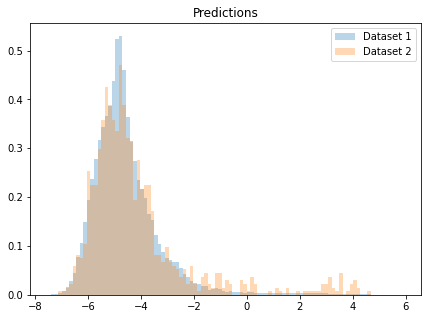

[DriftMetricsNum(mean_difference=0.3928404863865138, wasserstein=0.3943791206300099, ks_test=BaseStatisticalTestResult(statistic=0.07278203424859753, pvalue=5.198360975933121e-05))]

In [31]:
drift_explainer.plot_prediction_drift(bins=100)
drift_explainer.get_prediction_drift()

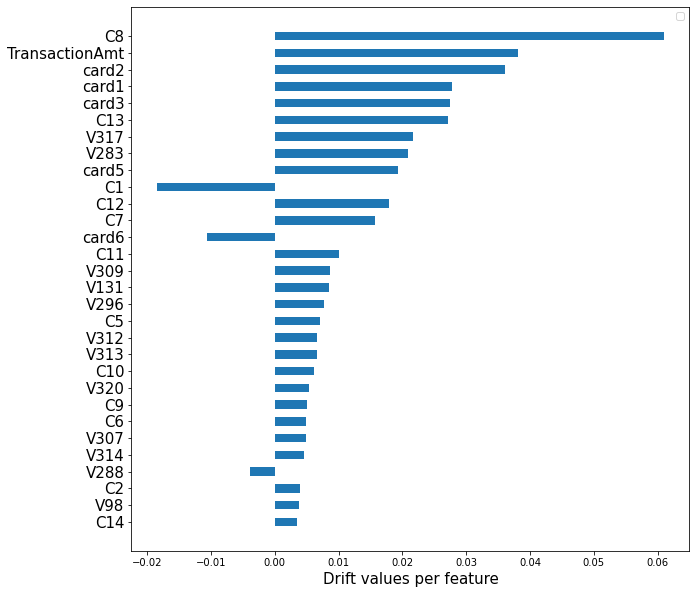

In [32]:
# rmk pres: sum of contributions sums to the mean difference
drift_explainer.plot_tree_based_drift_importances(type='mean', n=30)

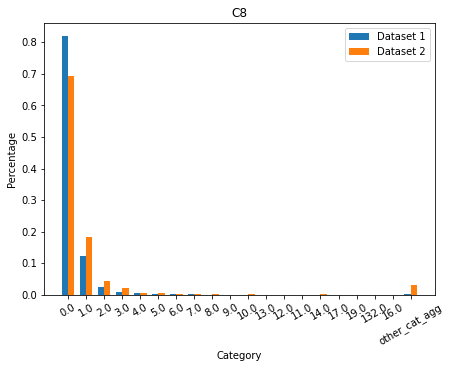

In [33]:
feature_name = 'C8'
drift_explainer.plot_feature_drift(feature_name)

In [34]:
print(df_temp2['isFraud'].mean())
partial_effects = df_temp2.groupby(feature_name)['isFraud'].agg(['mean', 'count'])
partial_effects[:20]

0.03306453597086901


,mean,count
C8,,
0.0,0.020543,233315
1.0,0.034899,70805
2.0,0.087169,9430
3.0,0.125041,3031
4.0,0.188525,1464
5.0,0.190639,876
6.0,0.220798,702
7.0,0.242424,528
8.0,0.232019,431


In [35]:
# explain why we finally take a threshold of 0.4
threshold = 0.4

# Simulate the run in production and the monitoring that would happen

In [36]:
prod_daily_indicators_df = get_daily_indicators_df(X1=X_valid, X2=X_prod, y1=y_valid, y2=y_prod, w=1000)

In [37]:
prod_daily_indicators_df

,pred_mean_difference,pred_wasserstein,pred_ks_pvalue
d0,-0.206314,0.209710,1.145890e-10
d1,-0.112135,0.126596,6.689408e-03
d2,-0.036760,0.154403,4.096384e-04
d3,-0.051047,0.062885,1.846423e-02
d4,-0.025836,0.079384,6.616678e-01
d5,0.005031,0.057374,2.435619e-01
d6,-0.155341,0.155391,9.314437e-03
d7,0.012084,0.073378,2.096182e-01
d8,-0.005242,0.032384,9.379020e-01
d9,-0.101288,0.121003,7.058145e-02


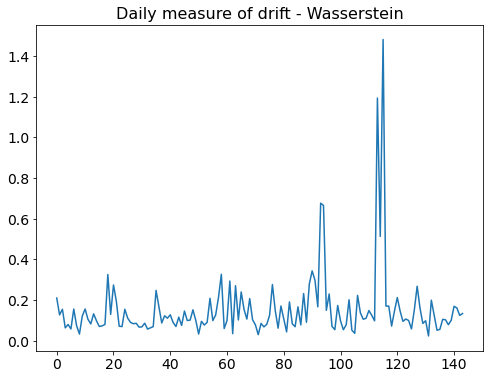

In [38]:
plt.subplots(figsize=(8, 6))
plt.plot(list(range(len(prod_daily_indicators_df))), prod_daily_indicators_df['pred_wasserstein'])
plt.title('Daily measure of drift - Wasserstein', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [39]:
# investigate on day 113
i=113
w=1000
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_valid, X2=X_prod.iloc[(i*w):(i+1)*w, :],
                    y1=y_valid, y2=y_prod[(i*w):(i+1)*w], cat_feature_indices=cat_feature_indices)

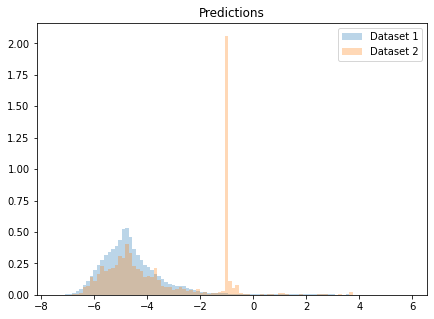

[DriftMetricsNum(mean_difference=1.191566753735489, wasserstein=1.1932868861292092, ks_test=BaseStatisticalTestResult(statistic=0.3119167404782993, pvalue=3.715985170852678e-86))]

In [40]:
drift_explainer.plot_prediction_drift(bins=100)
drift_explainer.get_prediction_drift()

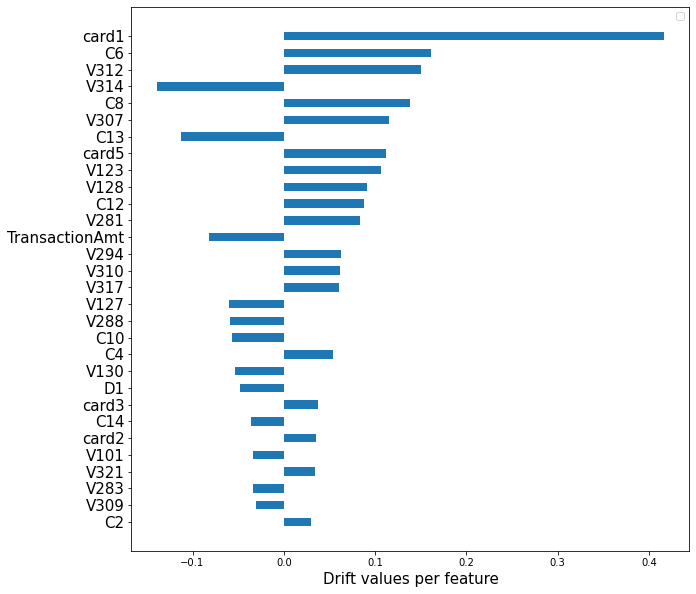

In [41]:
drift_explainer.plot_tree_based_drift_importances(n=30, type='mean')

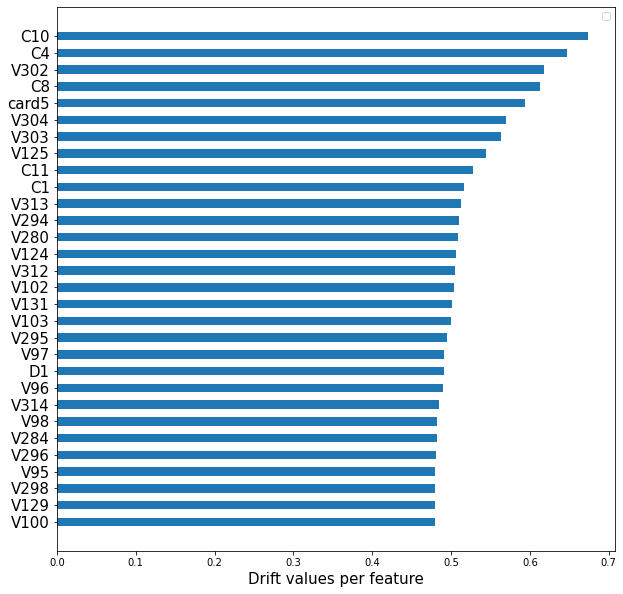

In [42]:
drift_explainer.plot_model_agnostic_drift_importances(n=30, type='mean')

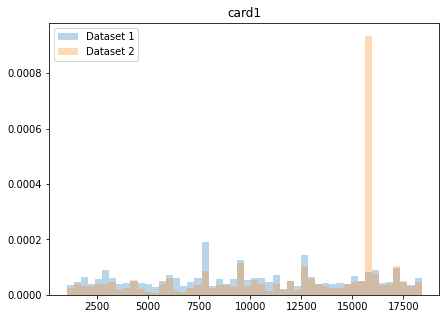

In [43]:
feature_name = 'card1'
drift_explainer.plot_feature_drift(feature_name, bins=50)

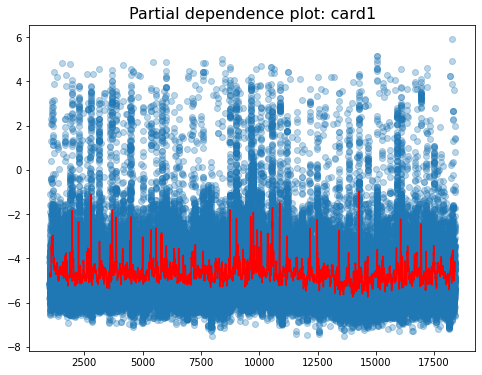

In [44]:
window = 100
plt.subplots(figsize=(8, 6))
plt.scatter(drift_explainer.X1[feature_name].values, drift_explainer.predictions1, alpha=0.3)
plt.plot(drift_explainer.X1[feature_name].sort_values().rolling(window=window, min_periods=1, center=True).mean(),
            pd.Series(drift_explainer.predictions1[np.argsort(drift_explainer.X1[feature_name])]).rolling(window=window, min_periods=1, center=True).mean(),
         color='red')
plt.title(f'Partial dependence plot: {feature_name}', fontsize=16)
plt.show()

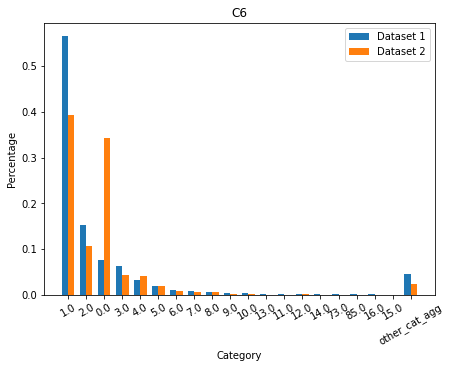

In [45]:
feature_name = 'C6'
drift_explainer.plot_feature_drift(feature_name, bins=50)

In [46]:
print(df_temp2['isFraud'].mean())
partial_effects = df_temp2.groupby(feature_name)['isFraud'].agg(['mean', 'count'])
partial_effects[:20]

0.03306453597086901


,mean,count
C6,,
0.0,0.026752,25643
1.0,0.024744,195081
2.0,0.039170,44932
3.0,0.045870,18160
4.0,0.059739,9190
5.0,0.060338,5204
6.0,0.087736,3180
7.0,0.072000,2125
8.0,0.075823,1609


# Is it possible to correct data drift on day 113 using a reweighting strategy ?

In [47]:
sample_weights_test_adversarial = (AdversarialDriftExplainer(seed=2021, feature_subset=['card1', 'C6', 'V314', 'V312']) # 
                                   .fit(X1=X_prod.iloc[(i*w):(i+1)*w, :], X2=X_valid)
                                    .get_adversarial_correction_weights(max_ratio=100))

[0]	validation_0-error:0.36236	validation_0-auc:0.67755	validation_0-logloss:0.67462
[10]	validation_0-error:0.34382	validation_0-auc:0.67590	validation_0-logloss:0.60818
[20]	validation_0-error:0.34623	validation_0-auc:0.67215	validation_0-logloss:0.60057
[30]	validation_0-error:0.34660	validation_0-auc:0.67346	validation_0-logloss:0.60247
[40]	validation_0-error:0.34547	validation_0-auc:0.67606	validation_0-logloss:0.60580
[42]	validation_0-error:0.34624	validation_0-auc:0.67590	validation_0-logloss:0.60718
[0]	validation_0-error:0.33850	validation_0-auc:0.66377	validation_0-logloss:0.67472
[10]	validation_0-error:0.34275	validation_0-auc:0.69430	validation_0-logloss:0.59814
[20]	validation_0-error:0.34065	validation_0-auc:0.69413	validation_0-logloss:0.58504
[30]	validation_0-error:0.33855	validation_0-auc:0.70130	validation_0-logloss:0.58412
[40]	validation_0-error:0.34089	validation_0-auc:0.69634	validation_0-logloss:0.58925
[48]	validation_0-error:0.34200	validation_0-auc:0.69410

In [48]:
# study the drift with the new weights on test data
drift_explainer2 = ModelDriftExplainer(clf)
drift_explainer2.fit(X1=X_valid, X2=X_prod.iloc[(i*w):(i+1)*w, :], y1=y_valid, y2=y_prod[(i*w):(i+1)*w],
                     sample_weights2=sample_weights_test_adversarial,
                     cat_feature_indices=cat_feature_indices)

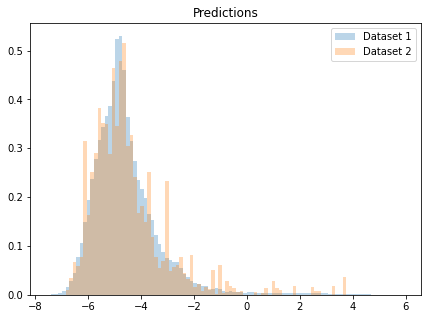

[DriftMetricsNum(mean_difference=0.11216416659091966, wasserstein=0.16314221701182918, ks_test=BaseStatisticalTestResult(statistic=0.04990129155934164, pvalue=0.013881136141010858))]

In [49]:
# reweighting manages to reduce the drift drastically
drift_explainer2.plot_prediction_drift(bins=100, prediction_type='raw')
drift_explainer2.get_prediction_drift(prediction_type='raw')

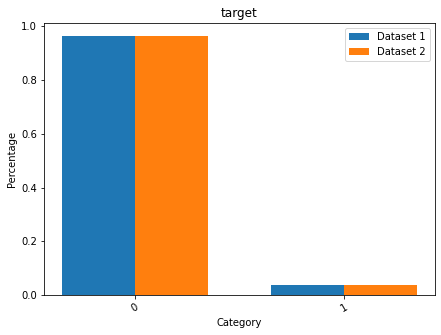

DriftMetricsCat(wasserstein=0.0014303259438901497, jensen_shannon=0.0026854594879523463, chi2_test=Chi2TestResult(statistic=0.023512983745740384, pvalue=0.8781306001000719, dof=1, contingency_table=                0            1
X1  104316.000000  4068.000000
X2     963.897111    36.102889))

In [50]:
drift_explainer2.plot_target_drift()
drift_explainer2.get_target_drift()

In [51]:
drift_explainer2.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=0.9727081488042516, log_loss=0.09980704829516686), dataset2=ClassificationMetrics(accuracy=0.9676290441767947, log_loss=0.08701969490656727))

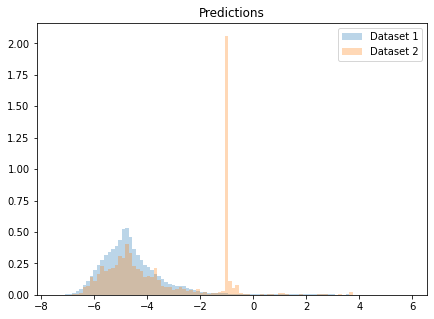

[DriftMetricsNum(mean_difference=1.191566753735489, wasserstein=1.1932868861292092, ks_test=BaseStatisticalTestResult(statistic=0.3119167404782993, pvalue=3.715985170852678e-86))]

In [52]:
drift_explainer.plot_prediction_drift(bins=100, prediction_type='raw')
drift_explainer.get_prediction_drift(prediction_type='raw')

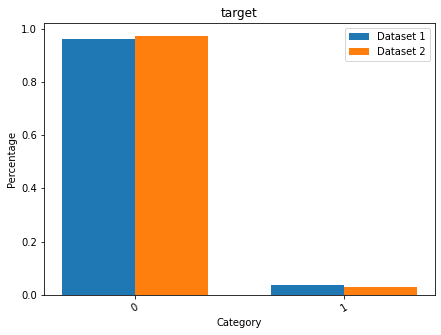

DriftMetricsCat(wasserstein=0.009533215234720971, jensen_shannon=0.01896526408183087, chi2_test=Chi2TestResult(statistic=2.240893258351462, pvalue=0.1344033173419487, dof=1, contingency_table=           0       1
X1  104316.0  4068.0
X2     972.0    28.0))

In [53]:
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [54]:
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=0.9727081488042516, log_loss=0.09980704829516686), dataset2=ClassificationMetrics(accuracy=0.972, log_loss=0.1692608628536109))